## Author: Fang Jung(Kristy) Lin
## Purpose: Build models for either video CTR that predicts CTR  values

## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import random
import os

from matplotlib import pyplot as plt
import pylab as pl
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
import seaborn as sns

import statsmodels.api as sm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pandas.plotting import autocorrelation_plot

## Purpose for the analysis

Using Moving Average with (k=x and k=y) (at least two alternatives), Exponential smoothing (alpha=a1 and alpha=a2) (at least two alternatives), AR and ARIMA. Select a performance measure for the model and pick the best performing model and explain the reasoning. 

# Part1. Data Acquisition and Pre-processing

Data Acquisition

The actual path to downloadable CSV is: https://docs.google.com/spreadsheets/d/e/2PACX-1vTgJhyrsS0_Y-BJWG-VEPzs9OUbOOoKac1RND4Ek8GDsC52c0ZK8yA9S6bY3dYPlQ/pub?gid=110718201&single=true&output=csv


### Read data from Google sheet and explore the data frame

In [2]:
data_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTgJhyrsS0_Y-BJWG-VEPzs9OUbOOoKac1RND4Ek8GDsC52c0ZK8yA9S6bY3dYPlQ/pub?gid=110718201&single=true&output=csv'
my_df = pd.read_csv(data_path)

my_df.head(3)

Date        Country    CTR
0  1/2/2019  United States  0.54%
1  1/3/2019  United States  0.51%
2  1/4/2019  United States  0.54%

### Interpret the data

In [3]:
list(my_df)

['Date', 'Country', 'CTR']

### Data preprocessing

Check both the datatypes and if there are missing values

In [4]:
print('Datatype:\n', my_df.dtypes)
print('Missing values:\n', my_df.isnull().any())

Datatype:
 Date       object
Country    object
CTR        object
dtype: object
Missing values:
 Date       False
Country    False
CTR        False
dtype: bool


### Change the data type

Change Date from object to Datetime

In [5]:
my_df['Date'] = pd.to_datetime(my_df['Date'])

Change CTR from object to float

In [6]:
# Change the data type to string 
my_df['CTR'] = my_df['CTR'].astype(str)

# Remove the % and change the data type to float
my_df['CTR'] = my_df['CTR'].str.rstrip('%').astype(float)/100.0

# show the result
my_df.head(1)

Date        Country     CTR
0 2019-01-02  United States  0.0054

### Visualize the data

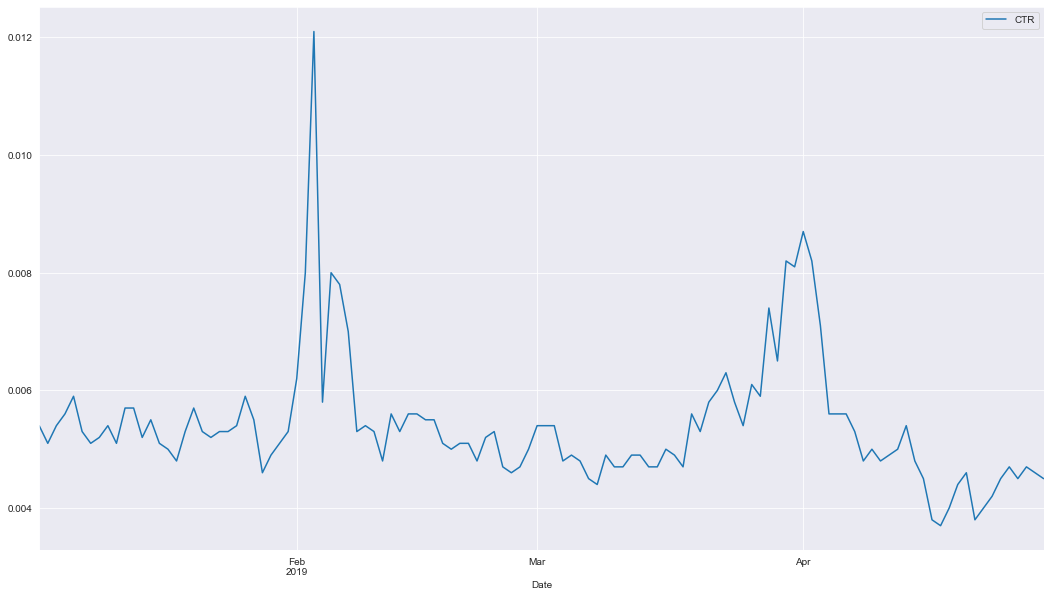

In [7]:
sns.set_style('darkgrid')

plot_df = my_df[['Date', 'CTR']]
plot_df.set_index('Date').plot(figsize=(18, 10))

### Initial analysis

As we can see from the graph, the data has a higher fluctuation in the beginning of February and the beginning of April. The overall trend of the data is quite stable and consistent.

# Part2. Moving average

For this part, I take reference from 
Joshua Emmanuel 'Forecasting: Moving Averages, MAD, MSE, MAPE': https://www.youtube.com/watch?v=Wo5YWXDRXv8&t=214s and write the function by myself to conduct the analysis.

### Define a moving average function

In [8]:
# Find the moving average value of the row
def rolling_row(df, n, old_col, new_col, row):
    if row < n:
        df[new_col][row] = np.nan
    total = 0
    for pre_row in range(row - n, row):
        total += df[old_col][pre_row]
    df[new_col][row] = total / n

# Find the moving average value of each row
def rolling_df(df, n, old_col, new_col):
    df[new_col] = np.nan
    for row in range(n, len(df.index)):
        rolling_row(df, n, old_col, new_col, row)

### Predict the CTR with k = 7, 15, 30

In [9]:
rolling_df(my_df, 7,  'CTR', 'CTR_7' )
rolling_df(my_df, 15, 'CTR', 'CTR_15')
rolling_df(my_df, 30, 'CTR', 'CTR_30')
my_df.head(35)

/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date        Country     CTR     CTR_7    CTR_15    CTR_30
0  2019-01-02  United States  0.0054       NaN       NaN       NaN
1  2019-01-03  United States  0.0051       NaN       NaN       NaN
2  2019-01-04  United States  0.0054       NaN       NaN       NaN
3  2019-01-05  United States  0.0056       NaN       NaN       NaN
4  2019-01-06  United States  0.0059       NaN       NaN       NaN
5  2019-01-07  United States  0.0053       NaN       NaN       NaN
6  2019-01-08  United States  0.0051       NaN       NaN       NaN
7  2019-01-09  United States  0.0052  0.005400       NaN       NaN
8  2019-01-10  United States  0.0054  0.005371       NaN       NaN
9  2019-01-11  United States  0.0051  0.005414       NaN       NaN
10 2019-01-12  United States  0.0057  0.005371       NaN       NaN
11 2019-01-13  United States  0.0057  0.005386       NaN       NaN
12 2019-01-14  United States  0.0052  0.005357       NaN       NaN
13 2019-01-15  United States  0.0055  0.005343       NaN       NaN
14 2019-01-16  United States  0.0051  0.005400       NaN       NaN
15 2019-01-17  United States  0.0050  0.005386  0.005380       NaN
16 2019-01-18  United States  0.0048  0.005329  0.005353       NaN
17 2019-01-19  United States  0.0053  0.005286  0.005333       NaN
18 2019-01-20  United States  0.0057  0.005229  0.005327       NaN
19 2019-01-21  United States  0.0053  0.005229  0.005333       NaN
20 2019-01-22  United States  0.0052  0.005243  0.005293       NaN
21 2019-01-23  United States  0.0053  0.005200  0.005287       NaN
22 2019-01-24  United States  0.0053  0.005229  0.005300       NaN
23 2019-01-25  United States  0.0054  0.005271  0.005307       NaN
24 2019-01-26  United States  0.0059  0.005357  0.005307       NaN
25 2019-01-27  United States  0.0055  0.005443  0.005360       NaN
26 2019-01-28  United States  0.0046  0.005414  0.005347       NaN
27 2019-01-29  United States  0.0049  0.005314  0.005273       NaN
28 2019-01-30  United States  0.0051  0.005271  0.005253       NaN
29 2019-01-31  United States  0.0053  0.005243  0.005227       NaN
30 2019-02-01  United States  0.0062  0.005243  0.005240  0.005310
31 2019-02-02  United States  0.0080  0.005357  0.005320  0.005337
32 2019-02-03  United States  0.0121  0.005657  0.005533  0.005433
33 2019-02-04  United States  0.0058  0.006600  0.005987  0.005657
34 2019-02-05  United States  0.0080  0.006771  0.005993  0.005663

### Visualize the result

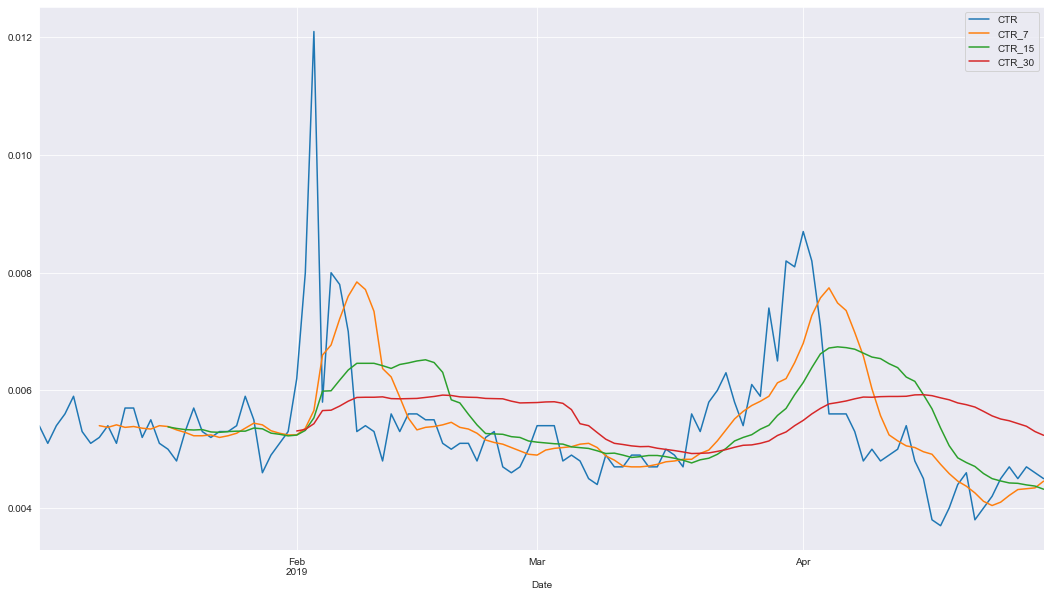

In [10]:
# plot original and transformed dataset
plot_df = my_df[['Date', 'CTR', 'CTR_7', 'CTR_15', 'CTR_30']]
plot_df.set_index('Date').plot(figsize=(18, 10))

### Summary

From the plot, we can find that when k=7 the trend of the CTR is closer to the trend of the actual value than others. However, the overall performance is not siginificant. The trend of moving average is much more smooth than the actual trend.

Let's take a look on the performance of MSE.

## Mean Square Error (MSE)

### Find the MSE when k = 7

In [11]:
# Create a new column and calculate error^2
my_df['error_CTR_7'] = pow(my_df['CTR_7'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_CTR_7 = my_df['error_CTR_7'][7:].mean()
MSE_CTR_7

1.0523092480235337e-06

### Find the MSE when k = 15

In [12]:
# Create a new column and calculate error^2
my_df['error_CTR_15'] = pow(my_df['CTR_15'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_CTR_15 = my_df['error_CTR_15'][15:].mean()
MSE_CTR_15

1.3806519956850055e-06

### Find the MSE when k = 30

In [13]:
# Create a new column and calculate error^2
my_df['error_CTR_30'] = pow(my_df['CTR_30'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_CTR_30 = my_df['error_CTR_30'][30:].mean()
MSE_CTR_30

1.8801074494949495e-06

### Summary

From the MSE score, we can find that when k=7, we get the smallest MSE score, which means that the accuracy of the prediction is higher.

Below, I will use exponential smoothing approach to find out if I can get a better predicion.

# Part3. Exponential smoothing

For this part, I take reference from 
Joshua Emmanuel 'Forecasting: Exponential Smoothing, MSE': https://www.youtube.com/watch?v=k_HN0wOKDd0 and write the function by myself to conduct the analysis.

### Define a exponential smoothing function

In [14]:
# Find the exponential smoothing value of each row
def exp_smooth(df, old_col, new_col, alpha):
    df[new_col] = np.nan
    df[new_col][0] = df[old_col][0]
    for i in range(1, len(df.index)):
        df[new_col][i] = alpha * df[old_col][i - 1] + (1 - alpha) * df[new_col][i - 1]

### Predict the CTR with alpha = 0.2, 0.5, 0.8

In [15]:
# Add the new columns to predict the CTR in differnt alpha
exp_smooth(my_df, 'CTR', 'Exp_CTR_0.2', 0.2)
exp_smooth(my_df, 'CTR', 'Exp_CTR_0.5', 0.5)
exp_smooth(my_df, 'CTR', 'Exp_CTR_0.8', 0.8)

# Show the dataframe
my_df.head(3)

/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date        Country     CTR  CTR_7  CTR_15  CTR_30  error_CTR_7  \
0 2019-01-02  United States  0.0054    NaN     NaN     NaN          NaN   
1 2019-01-03  United States  0.0051    NaN     NaN     NaN          NaN   
2 2019-01-04  United States  0.0054    NaN     NaN     NaN          NaN   

   error_CTR_15  error_CTR_30  Exp_CTR_0.2  Exp_CTR_0.5  Exp_CTR_0.8  
0           NaN           NaN      0.00540      0.00540      0.00540  
1           NaN           NaN      0.00540      0.00540      0.00540  
2           NaN           NaN      0.00534      0.00525      0.00516

### Visualize the result

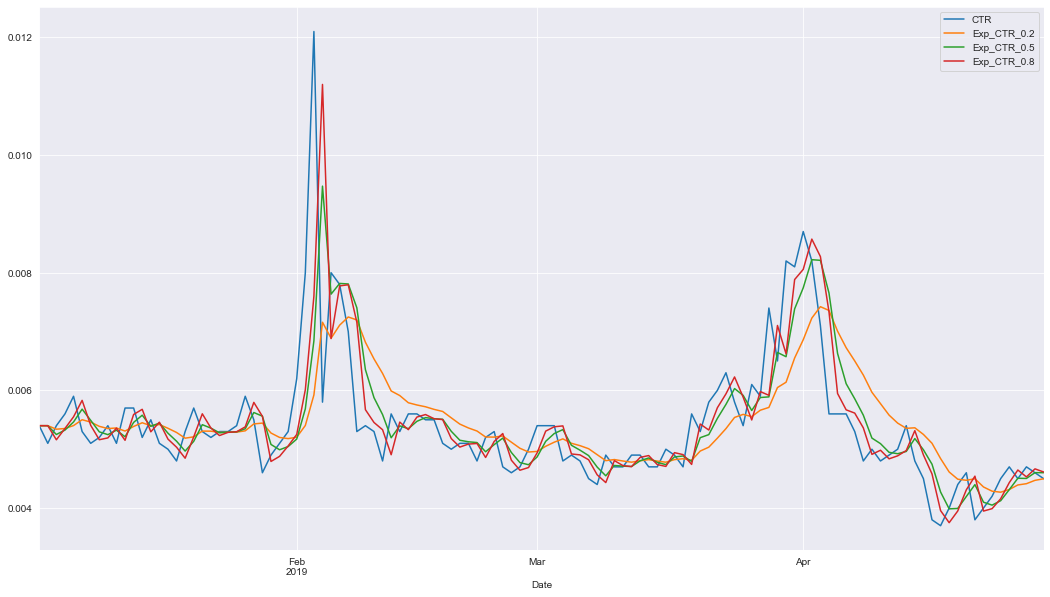

In [16]:
# plot original and transformed dataset
plot_df = my_df[['Date', 'CTR', 'Exp_CTR_0.2', 'Exp_CTR_0.5', 'Exp_CTR_0.8']]
plot_df.set_index('Date').plot(figsize=(18, 10))

### Summary

From the graph, we can find that the performance of exponential smoothing is better than moving average. We can find the significant higher peak in the beginning of Feb and Apr.

Let's take a look at the performance of MSE.

## Mean Square Error (MSE)

### Find the MSE when alpha = 0.2

In [17]:
# Create a new column and calculate error^2
my_df['exp_error_CTR_0.2'] = pow(my_df['Exp_CTR_0.2'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_EXP_CTR_2 = my_df['exp_error_CTR_0.2'][1:].mean()
MSE_EXP_CTR_2

8.601158653350715e-07

### Find the MSE when alpha = 0.5

In [18]:
# Create a new column and calculate error^2
my_df['exp_error_CTR_0.5'] = pow(my_df['Exp_CTR_0.5'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_EXP_CTR_5 = my_df['exp_error_CTR_0.5'][1:].mean()
MSE_EXP_CTR_5

6.789313556440972e-07

### Find the MSE when alpha = 0.8

In [19]:
# Create a new column and calculate error^2
my_df['exp_error_CTR_0.8'] = pow(my_df['Exp_CTR_0.8'] - my_df['CTR'], 2)

# Calculate the MSE
MSE_EXP_CTR_8 = my_df['exp_error_CTR_0.8'][1:].mean()
MSE_EXP_CTR_8

6.951252258012943e-07

### Summary

From the MSE, we can find we get the best MSE when alpha = 0.5, which is quite reasonable. The closer ALPHA is to 1, the less the prior data points enter into the smooth. The overall MSE are smaller than those of moving average. We can say that the performance of exponential smoothing is better than moving average.

Next, I will conduct the analysis on autoregression.

# Part4. Autoregression (AR)

For this part, I take reference from Jason Brownlee PhD 'Autoregression Models for Time Series Forecasting With Python': https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/ and train my model to see the result.

### Split the data into training set and testing set

In [20]:
# Split the data into training/testing sets
train_data, test_data = my_df[0:int(len(my_df)*0.9)], my_df[int(len(my_df)*0.9):]

train_CTR = train_data['CTR']
test_CTR = test_data['CTR']

### Train the AR model

In [21]:
# train autoregression model
model = AR(train_CTR)
model_fit = model.fit()

/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Fu

### Make predictions

In [22]:
# make predictions
predictions = model_fit.predict(
    start=len(train_CTR), 
    end=len(train_CTR) + len(test_CTR) - 1, 
    dynamic=False)

### Create a comparison dataframe of actual CTR and predict CTR

In [23]:
compare_df = pd.concat(
    [my_df['CTR'],
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})
compare_df.tail(15)

CTR  predicted
103  0.0045        NaN
104  0.0038        NaN
105  0.0037        NaN
106  0.0040   0.003959
107  0.0044   0.004147
108  0.0046   0.004512
109  0.0038   0.004847
110  0.0040   0.005243
111  0.0042   0.005376
112  0.0045   0.005474
113  0.0047   0.005481
114  0.0045   0.005482
115  0.0047   0.005478
116  0.0046   0.005527
117  0.0045   0.005596

### Visualize the result

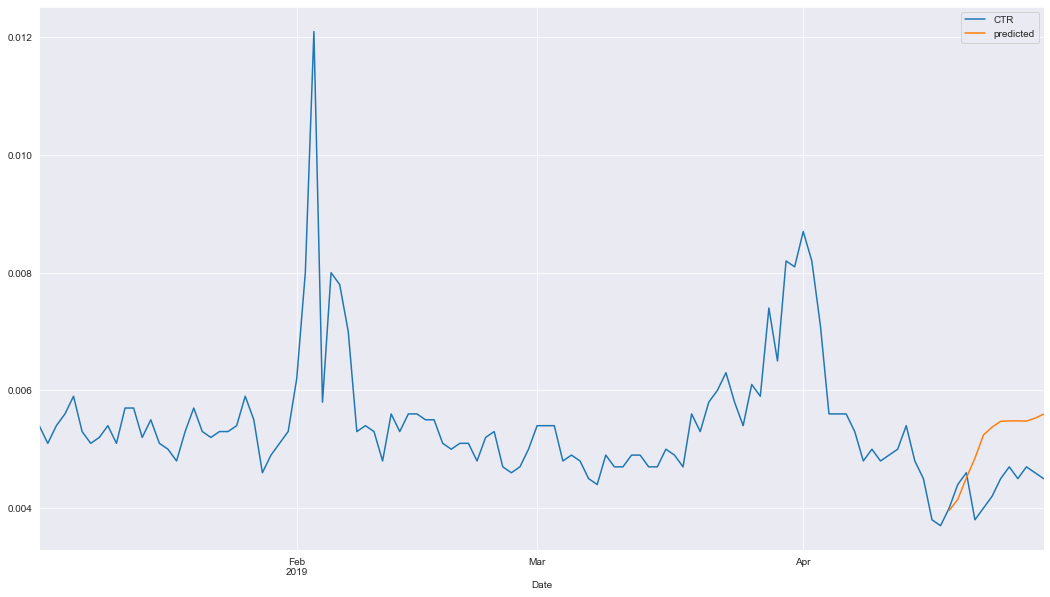

In [24]:
# Meger the compare_df with date
plot_df = pd.concat(
    [my_df['Date'],
    compare_df], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

# plot original and transformed dataset
plot_df.set_index('Date').plot(figsize=(18, 10))

### Summary

As we can see from the graph, the predicted values are not fitted to the acual value.

Let's take a deeper look at MSE

## Mean Square Error (MSE)

### Find the MSE/ MAE/ RMSE

In [25]:
AR_mse = mean_squared_error(test_CTR, predictions)
print('MSE: '+ str(AR_mse))
AR_mae = mean_absolute_error(test_CTR, predictions)
print('MAE: '+ str(AR_mae))
AR_rmse = sqrt(mean_squared_error(test_CTR, predictions))
print('RMSE: '+ str(AR_rmse))

MSE: 7.736730823198531e-07
MAE: 0.0007821000491073236
RMSE: 0.0008795868816210557


### Summary

The MSE is low, which means that the model performs well.

# Part5. Autoregressive Integrated Moving Average (ARIMA)

In this step, I used the same train/test sets data as AR model to train the ARIMA.

I take the reference from https://www.kaggle.com/bogdanbaraban/ar-arima-lstm to run my ARIMA model.

### Train the ARIMA model

In [26]:
# train ARIMA
history = [x for x in train_CTR]
ARIMA_model = ARIMA(history, order=(2,2,2))
ARIMA_model_fit = ARIMA_model.fit(disp=0)

/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Make prediction

In [27]:
y = test_CTR
# make first prediction
ARIMA_predictions_lst = list()
ARIMA_predictions = ARIMA_model_fit.forecast()[0]
ARIMA_predictions_lst.append(ARIMA_predictions)
history.append(y.iloc[0])

# rolling forecasts
for i in range(1, len(y)):
    # predict
    ARIMA_model = ARIMA(history, order=(2,2,2))
    ARIMA_model_fit = ARIMA_model.fit(disp=0)
    ARIMA_predictions = ARIMA_model_fit.forecast()[0]
    # invert transformed prediction
    ARIMA_predictions_lst.append(ARIMA_predictions)
    # observation
    obs = y.iloc[i]
    history.append(obs)
    
# Show the predictions
ARIMA_predictions_lst  

/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/kristylin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.

[array([0.00365501]),
 array([0.00378571]),
 array([0.00415587]),
 array([0.00445321]),
 array([0.0039935]),
 array([0.00384978]),
 array([0.00401433]),
 array([0.00433086]),
 array([0.00457751]),
 array([0.00452471]),
 array([0.00457524]),
 array([0.00456302])]

### Create a comparison dataframe of actual CTR and predict CTR

In [28]:
# Change the prediction values from np.array to dataframe
ARIMA_predictions_df = pd.DataFrame(data = ARIMA_predictions_lst)

# Reset the index
ARIMA_predictions_df.index += 106

# Merge and compare the value between actual and prediction
ARIMA_compare_df = pd.concat(
    [my_df['CTR'],
    ARIMA_predictions_df], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

# Show the dataframe
ARIMA_compare_df.tail(15)

CTR  predicted
103  0.0045        NaN
104  0.0038        NaN
105  0.0037        NaN
106  0.0040   0.003655
107  0.0044   0.003786
108  0.0046   0.004156
109  0.0038   0.004453
110  0.0040   0.003993
111  0.0042   0.003850
112  0.0045   0.004014
113  0.0047   0.004331
114  0.0045   0.004578
115  0.0047   0.004525
116  0.0046   0.004575
117  0.0045   0.004563

### Visualize the result

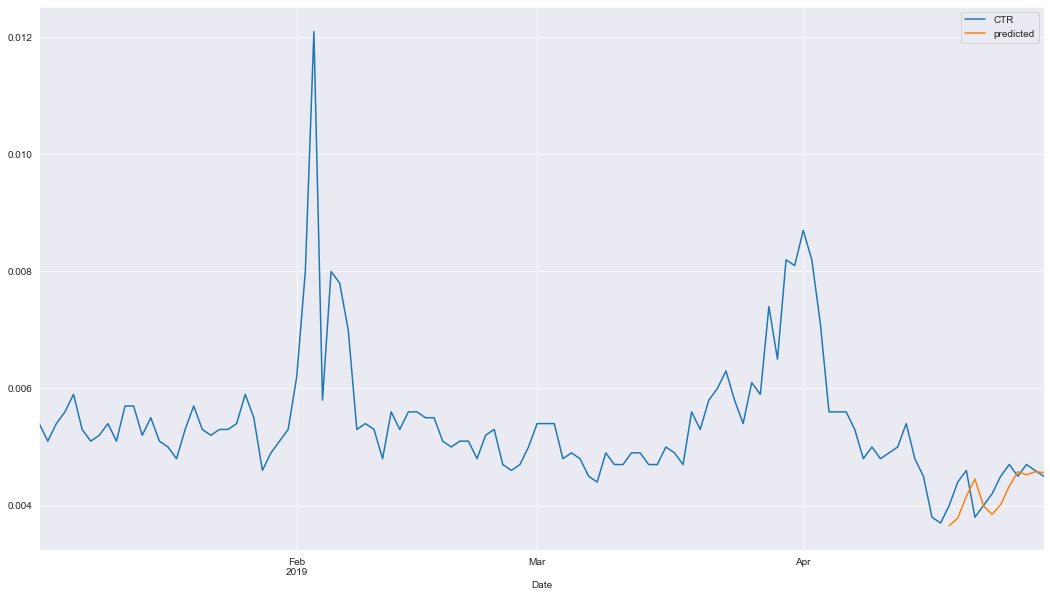

In [29]:
# Meger the compare_df with date
ARIMA_plot_df = pd.concat(
    [my_df['Date'],
    ARIMA_compare_df], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

# plot original and transformed dataset
ARIMA_plot_df.set_index('Date').plot(figsize=(18, 10))

### Summary

As we can see from the plot, the actual trend and the predicted trend are similiar.

Let's take a look at MSE performance

## Mean Square Error (MSE)

### Find the MSE/ MAE/ RMSE

In [30]:
ARIMA_mse = mean_squared_error(y, ARIMA_predictions_lst)
print('MSE: '+ str(ARIMA_mse))
ARIMA_mae = mean_absolute_error(y, ARIMA_predictions_lst)
print('MAE: '+ str(ARIMA_mae))
ARIMA_rmse = sqrt(mean_squared_error(y, ARIMA_predictions_lst))
print('RMSE: '+ str(ARIMA_rmse))

MSE: 1.3803795724542336e-07
MAE: 0.0003007270741096326
RMSE: 0.00037153459764256594


### Summary

The MSE of ARIMA is pretty low. The model looks good!

Now, let's put all together to compare the results among all different models. 

# Part6. Conclusion

Select a performance measure for the model and pick the best performing model and explain the reason.

### Build a MSE dataframe to compare the performance of each model

In [31]:
data = {'Model': ['Moving average MSE when k = 7 ', 'Moving average MSE when k = 15 ', 
        'Moving average MSE when k = 30 ', 'Exponential smoothing MSE when alpha = 0.2', 
        'Exponential smoothing MSE when alpha = 0.5', 
        'Exponential smoothing MSE when alpha = 0.8', 
        'Autoregression MSE', 'ARIMA MSE'] , 
        'MSE (unit = e-06)':[MSE_CTR_7 * 10**6, MSE_CTR_15 * 10**6, MSE_CTR_30 * 10**6,MSE_EXP_CTR_2 * 10**6, MSE_EXP_CTR_5 * 10**6, 
               MSE_EXP_CTR_8 * 10**6, AR_mse * 10**6, ARIMA_mse * 10**6]}

MSE_df = pd.DataFrame(data).sort_values(by = 'MSE (unit = e-06)').reset_index()
MSE_df[['Model', 'MSE (unit = e-06)']]

Model  MSE (unit = e-06)
0                                   ARIMA MSE           0.138038
1  Exponential smoothing MSE when alpha = 0.5           0.678931
2  Exponential smoothing MSE when alpha = 0.8           0.695125
3                          Autoregression MSE           0.773673
4  Exponential smoothing MSE when alpha = 0.2           0.860116
5              Moving average MSE when k = 7            1.052309
6             Moving average MSE when k = 15            1.380652
7             Moving average MSE when k = 30            1.880107

### Visualize the result

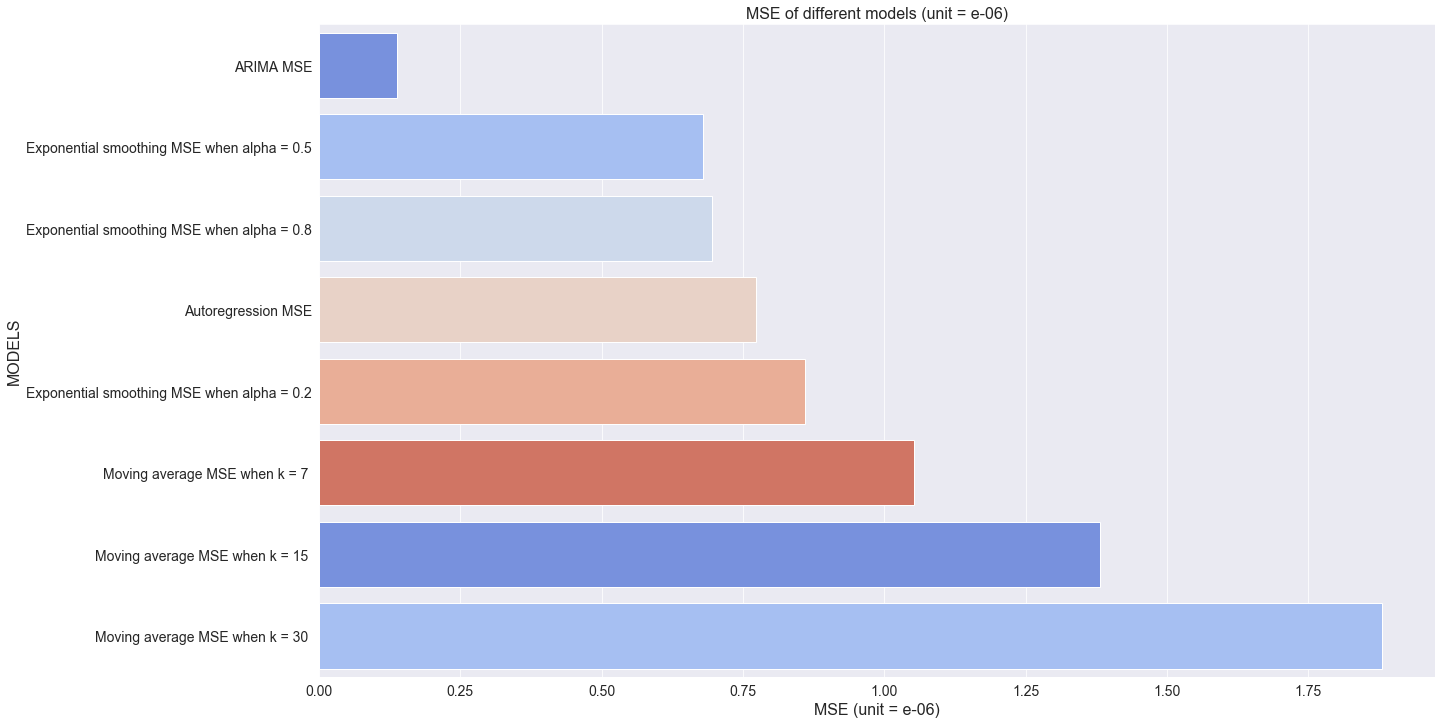

In [32]:
# Set figure size. 
rcParams['figure.figsize'] = (20, 12)
sns.set_style('darkgrid')

# Make barplot
ax = sns.barplot('MSE (unit = e-06)', 'Model', data = MSE_df, palette = sns.color_palette('coolwarm'), orient = 'h')

# Set x_label, y_label, plot title name.  
ax.set_xlabel('MSE (unit = e-06)', fontsize = 16)
ax.set_ylabel('MODELS', fontsize = 16)
ax.set_title('MSE of different models (unit = e-06)', fontsize = 16)

# Set the fontsize for x axis and y axis. 
ax.tick_params(axis = 'y', labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 14)

## Conclusion

- From the above comparison, we can find that ARIMA got the best performance. Hence, I will choose this model to conduct the analysis. The MSE score of it is much lower than others.

- Also, as we can see from the initial data, the overall trend of CTR looks quite stable, ARIMA works best when data exhibits a stable or consistent pattern over time with a minimum amount of outliers.

- However, I will not say that ARIMA must be the best model for this prediction. Our data term is quite small. If we can have a long-term data, the result might be different. But for this small data, ARIMA works well so I will choose it.

- The performances of Exponential Smoothing and AR are also pretty well. I got the similiar result among them.

- The performances of moving average are the worst among all the models.

# Part7. References

- For moving average, I take reference from Joshua Emmanuel 'Forecasting: Moving Averages, MAD, MSE, MAPE': https://www.youtube.com/watch?v=Wo5YWXDRXv8&t=214s 

- For exponential smoothing, I take reference from Joshua Emmanuel 'Forecasting: Exponential Smoothing, MSE': https://www.youtube.com/watch?v=k_HN0wOKDd0

- For autoregression, I take reference from Jason Brownlee PhD 'Autoregression Models for Time Series Forecasting With Python': https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/ 

- For ARIMA, I take the reference from https://www.kaggle.com/bogdanbaraban/ar-arima-lstm
